[[ 1.9   9.84 11.66  8.96  5.88]
 [ 1.9   7.68 21.12  2.56  5.88]
 [ 0.1   7.68 21.12  2.56 26.88]]


/home/d/Scrivania/My_venv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/d/Scrivania/My_venv/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


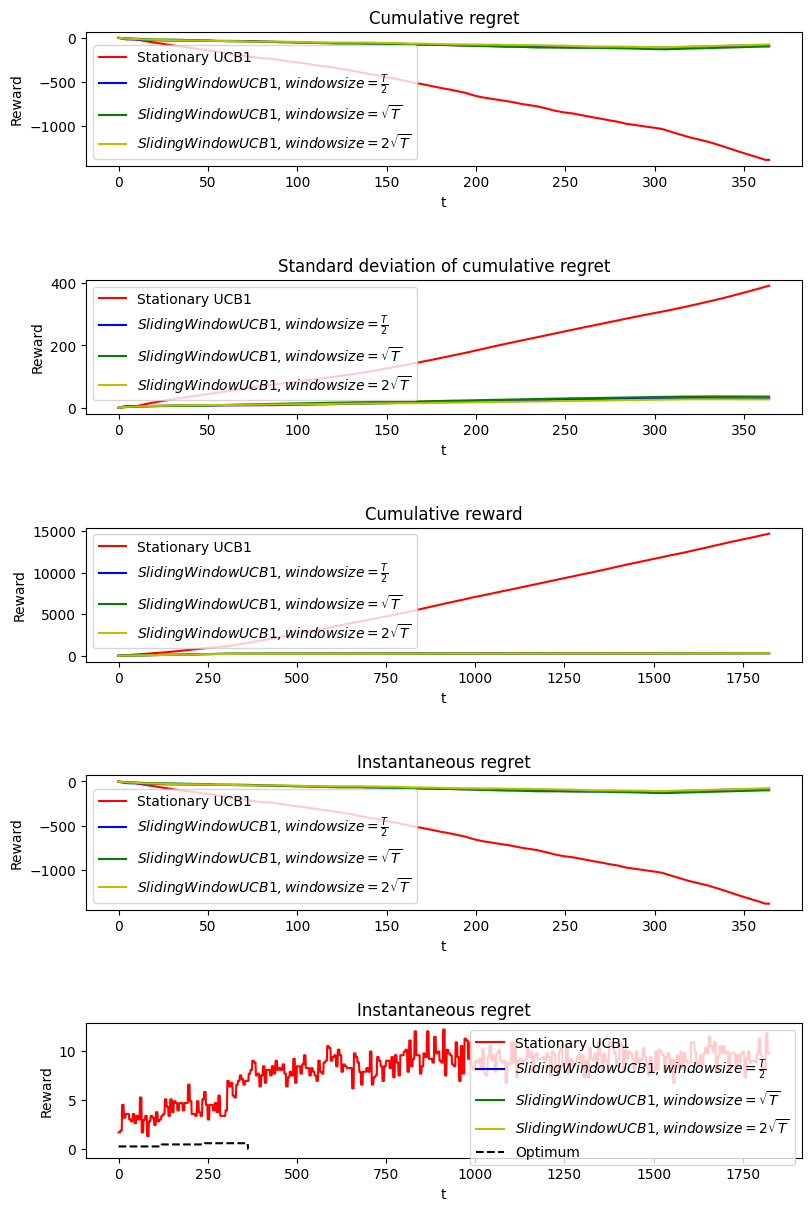

In [2]:
# %%
from UserClass import *
from UCB1_Learner import *
from Non_Stationary_Environment import *
from SWUCB_Learner import *
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt

n_arms = 5
c1 = UserClass(
    np.array([10, 20, 30, 40, 50]),
    np.array([[0.95, 0.82, 0.53, 0.28, 0.14], [0.95, 0.64, 0.96, 0.08, 0.14], [0.05, 0.64, 0.96, 0.08, 0.64]])
)
print((c1.prices - 8) * c1.probabilities)
prb = (c1.prices - 8) * c1.probabilities
prb = prb / np.sqrt(np.sum(prb ** 2))

T = 365
n_phases = 3
phases_len = int(T / n_phases)
n_experiments = 100
ucb1_rewards_per_experiment = []
swucb_w1_rewards_per_experiment = []
swucb_w2_rewards_per_experiment = []
swucb_w3_rewards_per_experiment = []

for e in range(0, n_experiments):
    env = Non_Stationary_Environment(prb, T, n_phases)
    ucb1_learner = UCB1_Learner(n_arms)
    swucb_learner_w1 = SWUCB_Learner(n_arms, int(T // 2))
    swucb_learner_w2 = SWUCB_Learner(n_arms, int(sqrt(T)))
    swucb_learner_w3 = SWUCB_Learner(n_arms, int(2 * sqrt(T)))

    for t in range(0, T):
        # UCB1
        pulled_arm = ucb1_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb1_learner.update(pulled_arm, reward)

        # UCB1 window size = T
        pulled_arm = swucb_learner_w1.pull_arm()
        reward = env.round(pulled_arm)
        swucb_learner_w1.update(pulled_arm, reward)

        # UCB1 window size = sqrt(T)
        pulled_arm = int(swucb_learner_w2.pull_arm())
        reward = env.round(pulled_arm)
        swucb_learner_w2.update(pulled_arm, reward)

        # UCB1 window size = 2
        pulled_arm = int(swucb_learner_w3.pull_arm())
        reward = env.round(pulled_arm)
        swucb_learner_w3.update(pulled_arm, reward)

    ucb1_rewards_per_experiment.append(ucb1_learner.collected_rewards)
    swucb_w1_rewards_per_experiment.append(swucb_learner_w1.collected_rewards)
    swucb_w2_rewards_per_experiment.append(swucb_learner_w2.collected_rewards)
    swucb_w3_rewards_per_experiment.append(swucb_learner_w3.collected_rewards)

ucb1_rewards_per_experiment = np.array(ucb1_rewards_per_experiment) * 18.741590113968453
swucb_w1_rewards_per_experiment = np.array(swucb_w1_rewards_per_experiment) * 18.741590113968453
swucb_w2_rewards_per_experiment = np.array(swucb_w2_rewards_per_experiment) * 18.741590113968453
swucb_w3_rewards_per_experiment = np.array(swucb_w3_rewards_per_experiment) * 18.741590113968453

ucb1_regret = np.zeros(T)
swucb_w1_regret = np.zeros(T)
swucb_w2_regret = np.zeros(T)
swucb_w3_regret = np.zeros(T)

ucb1_instantaneous_regret = np.zeros(T)
swucb_w1_instantaneous_regret = np.zeros(T)
swucb_w2_instantaneous_regret = np.zeros(T)
swucb_w3_instantaneous_regret = np.zeros(T)

opt_per_phase = prb.max(axis=1)
optimum_per_round = np.zeros(T)

for i in range(n_phases):
    t_index = range(i * phases_len, (i + 1) * phases_len)
    optimum_per_round[t_index] = opt_per_phase[i]

    # Regret
    ucb1_regret[t_index] = np.mean(opt_per_phase[i] - ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w3_rewards_per_experiment, axis=0)[t_index]

    # Instantaneous regret
    ucb1_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(swucb_w1_rewards_per_experiment, axis=0)[
        t_index]
    swucb_w2_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(swucb_w2_rewards_per_experiment, axis=0)[
        t_index]
    swucb_w3_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(swucb_w3_rewards_per_experiment, axis=0)[
        t_index]

fig, axes = plt.subplots(5, 1, figsize=(8, 12), dpi=100, layout="constrained", gridspec_kw={'hspace': 0.2})

# Cumulative regret
axes[0].set_title("Cumulative regret")
axes[0].set_xlabel('t')
axes[0].set_ylabel('Reward')
axes[0].plot(np.cumsum(ucb1_regret), 'r', label="Stationary UCB1")
axes[0].plot(np.cumsum(swucb_w1_regret), 'b', label=r"$Sliding Window UCB1, window size = \frac{T}{2}$")
axes[0].plot(np.cumsum(swucb_w2_regret), 'g', label=r"$Sliding Window UCB1, window size = \sqrt{T}$")
axes[0].plot(np.cumsum(swucb_w3_regret), 'y', label=r"$Sliding Window UCB1, window size = 2 \sqrt{T}$")
axes[0].legend(loc=0)

# Standard deviation of cumulative regret
stducb = [(np.cumsum(ucb1_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w1 = [(np.cumsum(swucb_w1_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w2 = [(np.cumsum(swucb_w2_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w3 = [(np.cumsum(swucb_w3_regret))[:i].std() for i in range(1, T + 1)]

axes[1].set_title("Standard deviation of cumulative regret")
axes[1].set_xlabel('t')
axes[1].set_ylabel('Reward')
axes[1].plot(stducb, 'r', label="Stationary UCB1")
axes[1].plot(stdswucb_w1, 'b', label=r"$Sliding Window UCB1, window size = \frac{T}{2}$")
axes[1].plot(stdswucb_w2, 'g', label=r"$Sliding Window UCB1, window size = \sqrt{T}$")
axes[1].plot(stdswucb_w3, 'y', label=r"$Sliding Window UCB1, window size = 2 \sqrt{T}$")
axes[1].legend(loc=0)

# Cumulative reward
axes[2].set_title("Cumulative reward")
axes[2].set_xlabel('t')
axes[2].set_ylabel('Reward')
axes[2].plot(np.cumsum(np.mean(ucb1_rewards_per_experiment, axis=0)), 'r', label="Stationary UCB1")
axes[2].plot(np.cumsum(np.mean(swucb_w1_rewards_per_experiment, axis=0)), 'b',
                label=r"$Sliding Window UCB1, window size = \frac{T}{2}$")
axes[2].plot(np.cumsum(np.mean(swucb_w2_rewards_per_experiment, axis=0)), 'g',
                label=r"$Sliding Window UCB1, window size = \sqrt{T}$")
axes[2].plot(np.cumsum(np.mean(swucb_w3_rewards_per_experiment, axis=0)), 'y',
                label=r"$Sliding Window UCB1, window size = 2 \sqrt{T}$")
axes[2].legend(loc=0)

# Instantaneous regret
axes[3].set_title("Instantaneous regret")
axes[3].set_xlabel('t')
axes[3].set_ylabel('Reward')
axes[3].plot(np.cumsum(ucb1_instantaneous_regret), 'r', label="Stationary UCB1")
axes[3].plot(np.cumsum(swucb_w1_instantaneous_regret), 'b',
                label=r"$Sliding Window UCB1, window size = \frac{T}{2}$")
axes[3].plot(np.cumsum(swucb_w2_instantaneous_regret), 'g', label=r"$Sliding Window UCB1, window size = \sqrt{T}$")
axes[3].plot(np.cumsum(swucb_w3_instantaneous_regret), 'y', label=r"$Sliding Window UCB1, window size = 2 \sqrt{T}$")
axes[3].legend(loc=0)

# Instantaneous reward
axes[4].set_title("Instantaneous regret")
axes[4].set_xlabel('t')
axes[4].set_ylabel('Reward')
axes[4].plot(np.mean(ucb1_rewards_per_experiment, axis=0), 'r', label="Stationary UCB1")
axes[4].plot(np.mean(swucb_w1_instantaneous_regret, axis=0), 'b',
                label=r"$Sliding Window UCB1, window size = \frac{T}{2}$")
axes[4].plot(np.mean(swucb_w2_instantaneous_regret, axis=0), 'g',
                label=r"$Sliding Window UCB1, window size = \sqrt{T}$")
axes[4].plot(np.mean(swucb_w3_instantaneous_regret, axis=0), 'y',
                label=r"$Sliding Window UCB1, window size = 2 \sqrt{T}$")
axes[4].plot(optimum_per_round, 'k--', label="Optimum")
axes[4].legend(loc=0)

plt.show()